In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import category_encoders as ce
import catboost
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler
# import xgboost as xgb
# from xgboost import XGBClassifier
# from xgboost import plot_importance
%matplotlib inline 
pd.options.display.max_columns = None

In [2]:
X_train = pd.read_csv("train_values.csv")
y_train = pd.read_csv("train_labels.csv")
train = pd.concat([X_train, y_train], axis=1)
train.head(5)

,row_id,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,applicant_ethnicity,applicant_race,applicant_sex,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,lender,co_applicant,row_id,accepted
0,0,3,1,1,1,70.0,3,18,37,246,2,5,1,24.0,6203.0,44.230,60588.0,50.933,716.0,2642.0,4536,False,0,1
1,1,1,1,3,1,178.0,3,369,52,299,1,5,1,57.0,5774.0,15.905,54821.0,100.000,1622.0,2108.0,2458,False,1,0
2,2,2,1,3,1,163.0,3,16,10,306,2,5,1,67.0,6094.0,61.270,67719.0,100.000,760.0,1048.0,5710,False,2,1
3,3,1,1,1,1,155.0,1,305,47,180,2,5,1,105.0,6667.0,6.246,78439.0,100.000,2025.0,2299.0,5888,True,3,1
4,4,1,1,1,1,305.0,3,24,37,20,2,3,2,71.0,6732.0,100.000,63075.0,82.200,1464.0,1847.0,289,False,4,1


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 24 columns):
row_id                            500000 non-null int64
loan_type                         500000 non-null int64
property_type                     500000 non-null int64
loan_purpose                      500000 non-null int64
occupancy                         500000 non-null int64
loan_amount                       500000 non-null float64
preapproval                       500000 non-null int64
msa_md                            500000 non-null int64
state_code                        500000 non-null int64
county_code                       500000 non-null int64
applicant_ethnicity               500000 non-null int64
applicant_race                    500000 non-null int64
applicant_sex                     500000 non-null int64
applicant_income                  460052 non-null float64
population                        477535 non-null float64
minority_population_pct           477534 no

In [4]:
train.drop("row_id", axis=1, inplace=True)

replace_dict = {
    'msa_md': -1,
    'state_code': -1,
    'county_code': -1,
    'occupancy': 3,
    'preapproval': 3,
    'applicant_ethnicity': [3, 4, 5],
    "applicant_race": [6, 7, 8],
    "applicant_sex": [3, 4, 5]
}

cat_cols_few = ["loan_type", "property_type", "loan_purpose", "occupancy", "preapproval",
                "applicant_ethnicity", "applicant_race", "applicant_sex", "co_applicant"] 

cat_cols_many = ["msa_md", "state_code", "county_code", "lender"]

numerical_cols = ["loan_amount", "applicant_income", "population", "minority_population_pct",
                 "ffiecmedian_family_income", "tract_to_msa_md_income_pct",
                 "number_of_owner-occupied_units", "number_of_1_to_4_family_units"]

train.replace(replace_dict, np.nan, inplace = True)
train.count()

loan_type                         500000
property_type                     500000
loan_purpose                      500000
occupancy                         497811
loan_amount                       500000
preapproval                        88891
msa_md                            423018
state_code                        480868
county_code                       479534
applicant_ethnicity               436883
applicant_race                    434460
applicant_sex                     458682
applicant_income                  460052
population                        477535
minority_population_pct           477534
ffiecmedian_family_income         477560
tract_to_msa_md_income_pct        477486
number_of_owner-occupied_units    477435
number_of_1_to_4_family_units     477470
lender                            500000
co_applicant                      500000
accepted                          500000
dtype: int64

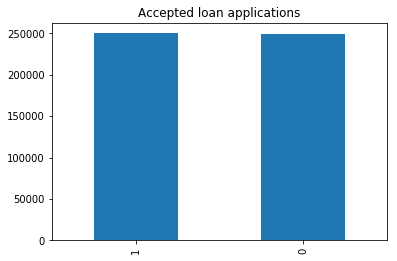

1    0.500228
0    0.499772
Name: accepted, dtype: float64

In [5]:
train["accepted"].value_counts().plot(kind='bar')
plt.title('Accepted loan applications')
plt.show()
train["accepted"].value_counts(normalize = 'index')

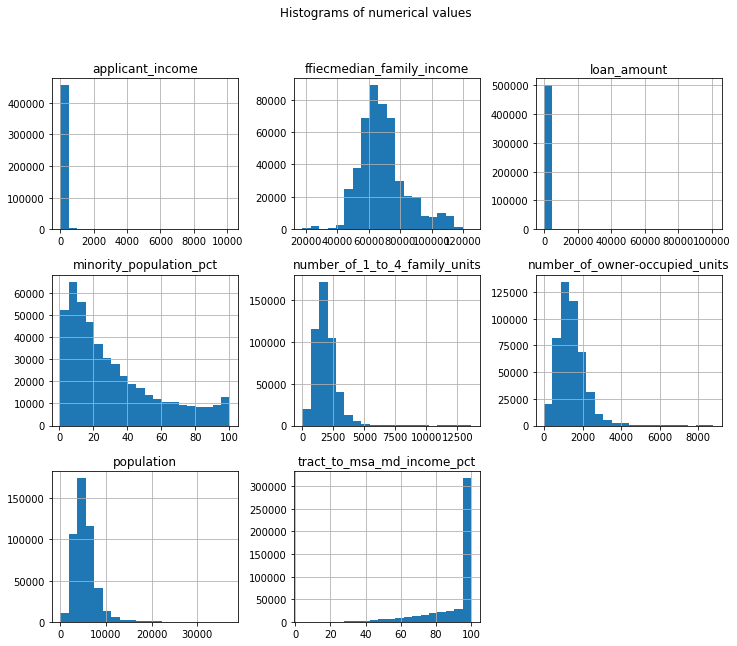

Skewness of numerical columns:


loan_amount                       76.552786
applicant_income                  22.277181
population                         2.864237
minority_population_pct            1.009139
ffiecmedian_family_income          0.773280
tract_to_msa_md_income_pct        -1.963872
number_of_owner-occupied_units     1.881743
number_of_1_to_4_family_units      2.016264
dtype: float64

In [6]:
train[numerical_cols].hist(figsize=(12,10), bins=20)
plt.suptitle("Histograms of numerical values")
plt.show()

print("Skewness of numerical columns:")
train[numerical_cols].skew()

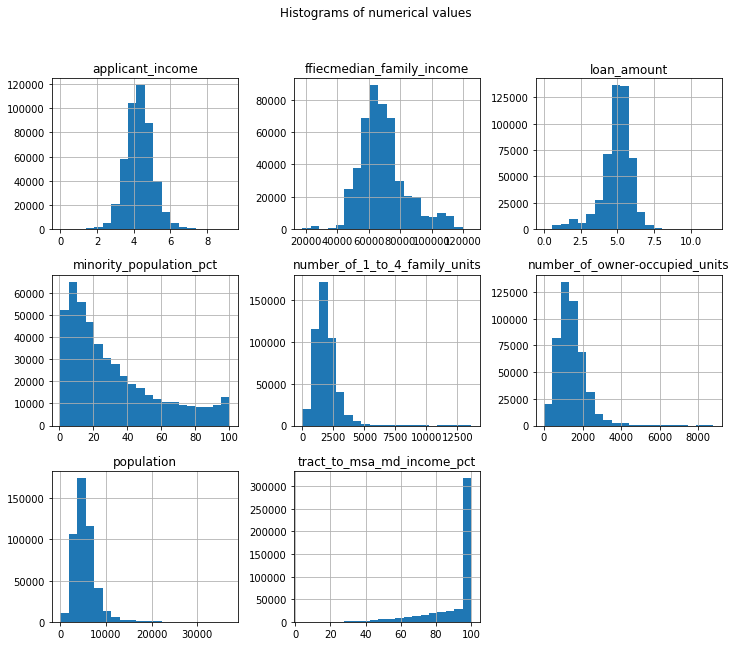

Skewness of numerical columns after applying log function:


loan_amount                      -1.190548
applicant_income                  0.026275
population                        2.864237
minority_population_pct           1.009139
ffiecmedian_family_income         0.773280
tract_to_msa_md_income_pct       -1.963872
number_of_owner-occupied_units    1.881743
number_of_1_to_4_family_units     2.016264
dtype: float64

In [7]:
import math
to_log = ["loan_amount", "applicant_income"]
train[to_log] = train[to_log].applymap(math.log)

train[numerical_cols].hist(figsize=(12,10), bins=20)
plt.suptitle("Histograms of numerical values")
plt.show()

print("Skewness of numerical columns after applying log function:")
train[numerical_cols].skew()

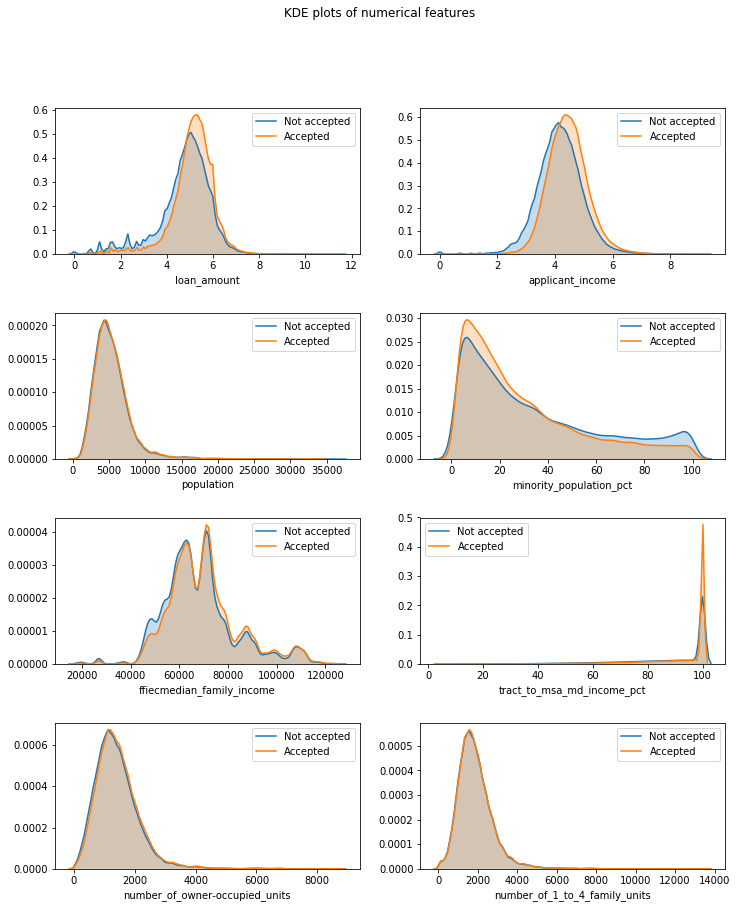

In [8]:
import warnings
warnings.filterwarnings("ignore")

fig, axes = plt.subplots(ncols = 2, nrows = 4, figsize = (12,14))
fig.subplots_adjust(hspace = 0.4, wspace = 0.2)
fig.suptitle("KDE plots of numerical features")

for ax, col in zip(axes.flatten(), numerical_cols) :
    sns.kdeplot(train[train["accepted"] == 0][col], shade="True", label="Not accepted", ax = ax)
    sns.kdeplot(train[train["accepted"] == 1][col], shade="True", label="Accepted", ax = ax)
    ax.set_xlabel(col)

In [9]:
train["minority_population"] = (train["minority_population_pct"] / 100) * (train["population"])
train["tract_family_income"] = (train["tract_to_msa_md_income_pct"] /100) * (train["ffiecmedian_family_income"])

train["minority_population"] = train["minority_population"].apply(math.log)

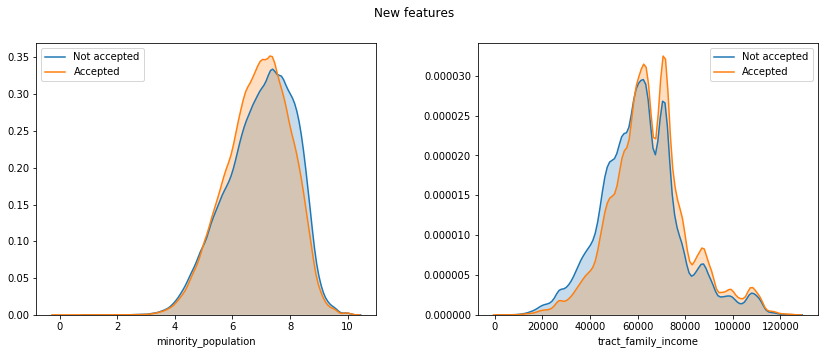

In [10]:
new_cols = ["minority_population", "tract_family_income"]

fig, axes = plt.subplots(ncols = 2, nrows = 1, figsize = (14,5))
fig.subplots_adjust(hspace = 0.5, wspace = 0.3)
fig.suptitle("New features")

for ax, col in zip(axes.flatten(), new_cols) :
    sns.kdeplot(train[train["accepted"] == 0][col], shade="True", label="Not accepted", ax = ax)
    sns.kdeplot(train[train["accepted"] == 1][col], shade="True", label="Accepted", ax = ax)
    ax.set_xlabel(col)

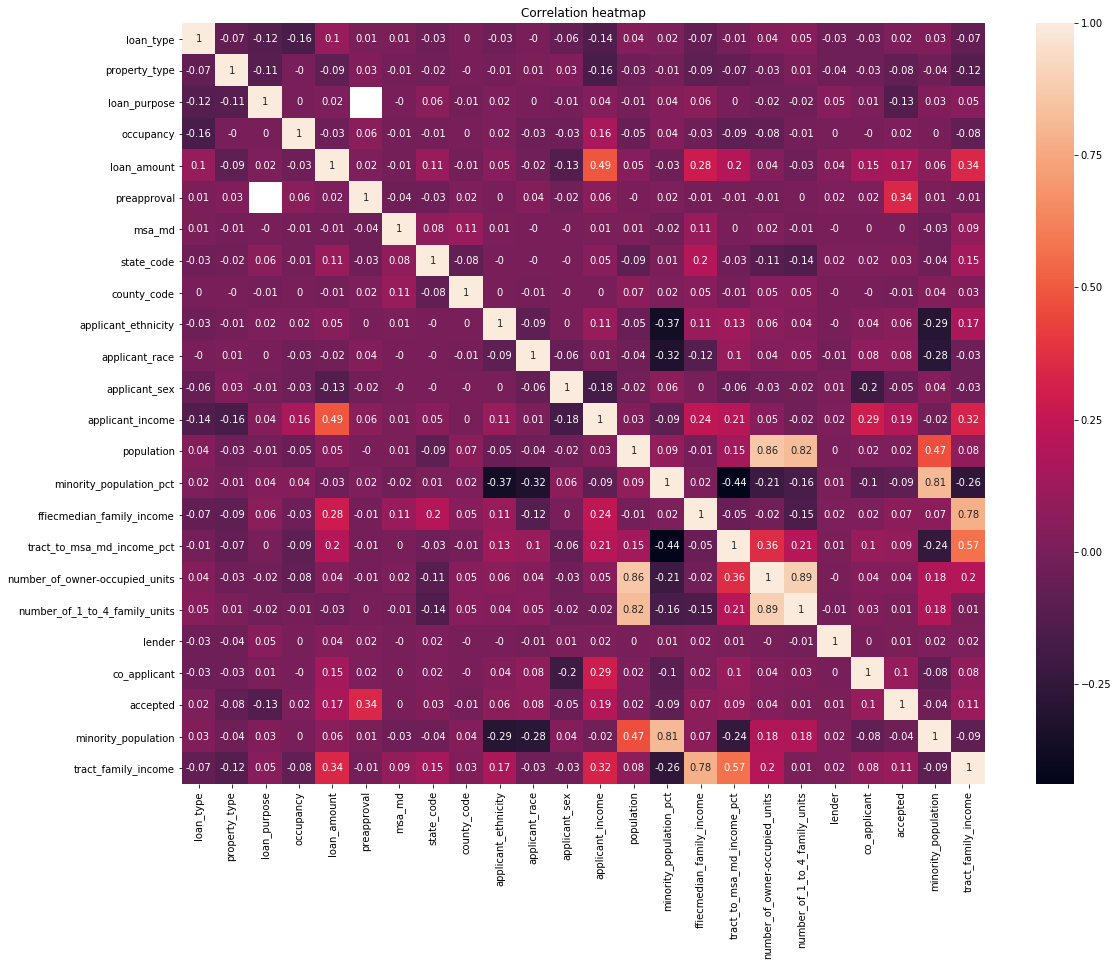

In [11]:
plt.figure(figsize=(18,14))
sns.heatmap(train.corr().round(decimals=2), annot=True)
plt.title("Correlation heatmap")
plt.show()

In [12]:
to_log = ["loan_amount", "applicant_income", "number_of_owner-occupied_units",
          "number_of_1_to_4_family_units", "minority_population"]

to_drop = ["row_id", "number_of_1_to_4_family_units",
           "occupancy", "preapproval", "county_code"]

num_cols = ["loan_amount", "applicant_income", "population", "minority_population_pct",
            "ffiecmedian_family_income", "tract_to_msa_md_income_pct",
            "number_of_owner-occupied_units"]

cat_cols_few = ["loan_type", "property_type", "loan_purpose",
            "applicant_ethnicity", "applicant_race",
            "applicant_sex", "co_applicant"]

def prepare_data(df):
    
    df["co_applicant"] = df["co_applicant"].astype("int8")
    df.replace(replace_dict, np.nan, inplace = True)
    
    
    for col in num_cols:
        df[col].fillna(df[col].median(), inplace=True)
        
    for col in cat_cols_few:
        df[col].fillna(df[col].mode()[0], inplace=True)
    
    df['Capacity%'] = ((df['loan_amount'] / df['applicant_income']) *100).astype(float)
    
    df["minority_population"] = (df["minority_population_pct"] / 100) * (df["population"])
    df["tract_family_income"] = (df["tract_to_msa_md_income_pct"] / 100) * (df["ffiecmedian_family_income"])

    df[to_log] = df[to_log].applymap(math.log)
    
    to_drop.extend(["minority_population_pct", "population",
                    "ffiecmedian_family_income", "tract_to_msa_md_income_pct"])
    df.drop(to_drop, axis=1, inplace=True)
    
    df = pd.get_dummies(df, columns = cat_cols_few)
    
    return df

In [13]:
X_train = prepare_data(X_train)

ce_target = ce.TargetEncoder(cols = ["lender", "msa_md", "state_code"], smoothing = 5, return_df = True)
X_train = ce_target.fit_transform(X_train, y_train["accepted"])

In [14]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 30 columns):
loan_amount                       500000 non-null float64
msa_md                            500000 non-null float64
state_code                        500000 non-null float64
applicant_income                  500000 non-null float64
number_of_owner-occupied_units    500000 non-null float64
lender                            500000 non-null float64
Capacity%                         500000 non-null float64
minority_population               500000 non-null float64
tract_family_income               500000 non-null float64
loan_type_1                       500000 non-null uint8
loan_type_2                       500000 non-null uint8
loan_type_3                       500000 non-null uint8
loan_type_4                       500000 non-null uint8
property_type_1                   500000 non-null uint8
property_type_2                   500000 non-null uint8
property_type_3                

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_train.values, y_train["accepted"].values, test_size=0.3, random_state=0)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)